In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams.update({'lines.markersize': 20})

np.random.seed(0)

In [2]:
import Preprocessor
import Parameters
import HHMM
import Visualisor

In [3]:
train_new = False

In [4]:
pars = Parameters.Parameters()

pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'Ahat_low':{'thresh':5,'corr':False,'f':'gamma'},
                  'Ax':{'corr':True,'f':'normal'},
                  'Ay':{'corr':True,'f':'normal'},
                  'Az':{'corr':True,'f':'normal'}}]

prep = Preprocessor.Preprocessor(pars)

In [5]:
np.set_printoptions(suppress=True,precision=4)

In [6]:
s_dive = 0
e_dive = 266
pars.K[0] = 2
pars.K[1] = 3
pars.share_fine_states = True
HHMM_file = '../Params/HHMM_k_%s_%s_dives_%s_%s_same_fine_states_A' % (pars.K[0],pars.K[1],s_dive,e_dive)
print(HHMM_file)

../Params/HHMM_k_2_3_dives_0_266_same_fine_states_A


# Preprocess Data

In [7]:
df = prep.load_data(pars.cvc_file,
                    pars.csv_file,
                    pars.cvc_cols)

df = prep.prune_cols(df)

df = prep.prune_times(df,
                      pars.stime,
                      pars.etime,
                      pars.drop_times)

df = prep.fix_pressure(df)

df = prep.find_Vz(df)

df = prep.smooth_columns(df,
                         pars.smoother,
                         pars.smooth_cols)

df,dive_df = prep.find_dives(df)

data = prep.get_all_features(df,dive_df)

viz = Visualisor.Visualisor(pars,data,df)

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



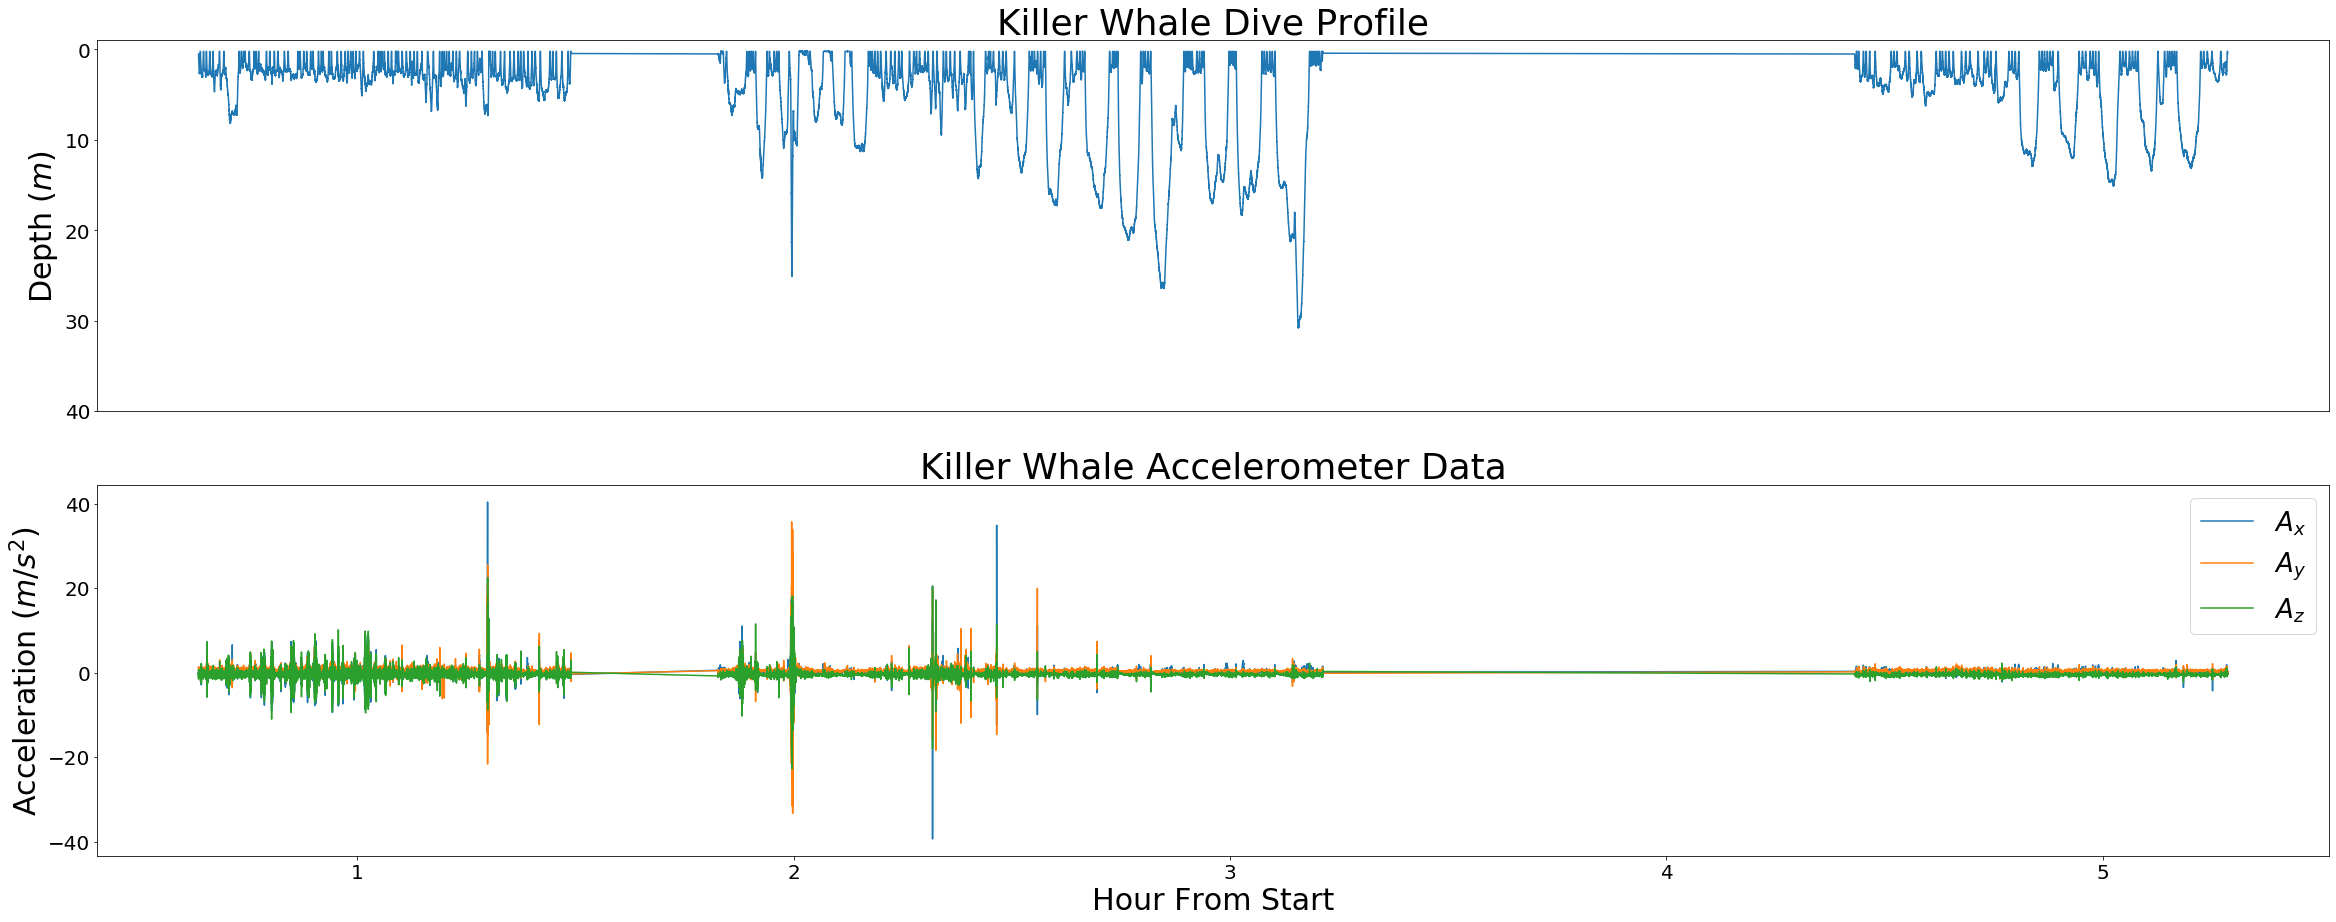

In [8]:
plt.subplots(2,1,figsize = (40,15))

plt.subplot(2,1,1)
plt.plot(df['hr_from_start'],df['depth'])
plt.title('Killer Whale Dive Profile',fontsize=36)
plt.ylim([40,-1])
plt.xticks([])
plt.ylabel('Depth $(m)$',fontsize=30)
plt.yticks(fontsize=20)

plt.subplot(2,1,2)
plt.plot(df['hr_from_start'],df['Ax'])
plt.plot(df['hr_from_start'],df['Ay'])
plt.plot(df['hr_from_start'],df['Az'])
plt.legend(['$A_x$','$A_y$','$A_z$'],prop={'size':26})
plt.title('Killer Whale Accelerometer Data',fontsize=36)
plt.xlabel('Hour From Start',fontsize=30)
plt.xticks(fontsize=20)
plt.ylabel('Acceleration $(m/s^2)$',fontsize=30)
plt.yticks(fontsize=20)
plt.savefig('../Plots/raw_data.png')
plt.show()

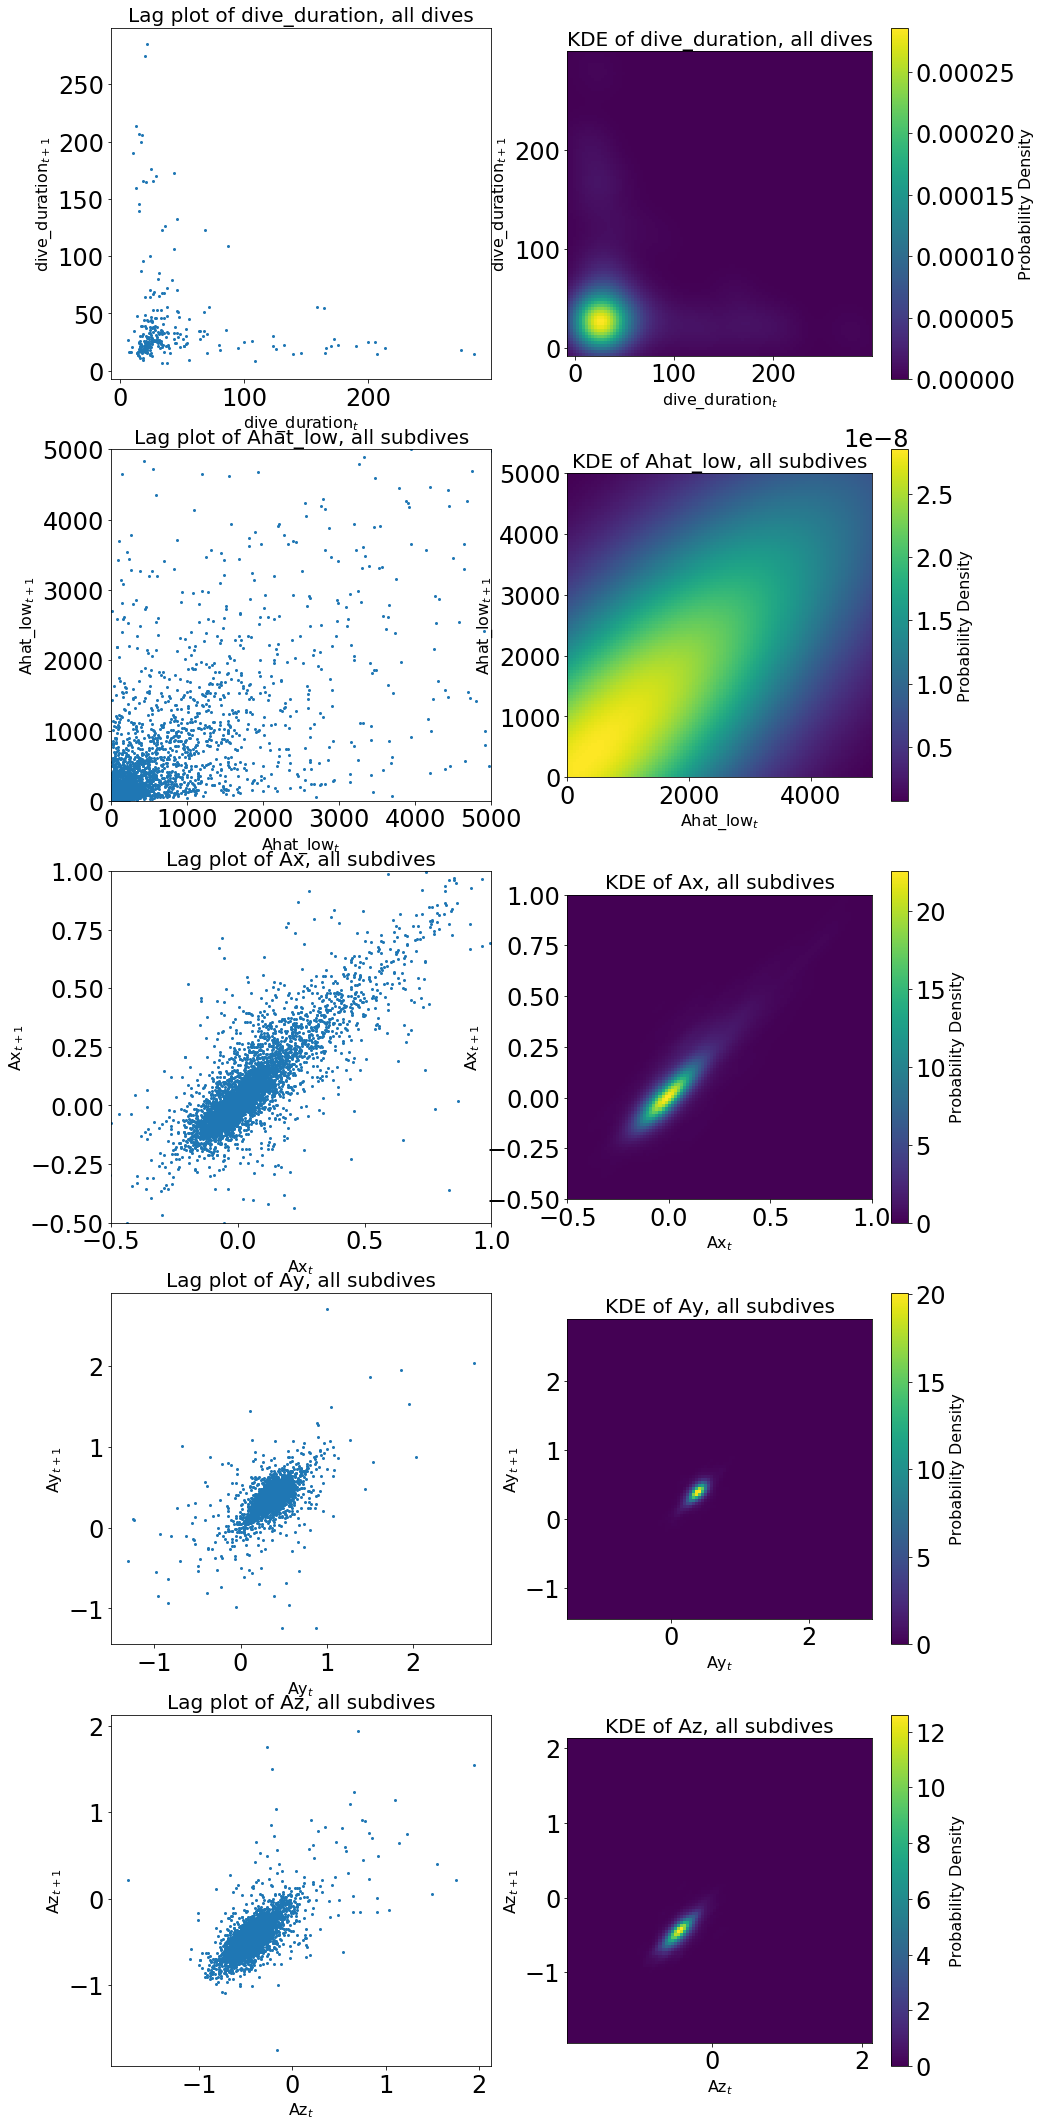

In [9]:
viz.lagplot(lims={'peak_jerk':[0,50],
                  'roll_at_pj':[0,1],
                  'heading_var':[0,0.2],
                  'Ahat_low':[0,5000],
                  'FoVeDBA_high':[0,10],
                  'Vz':[-5,5],
                  'Ax':[-0.5,1]})

# Train HHMM

In [10]:
deep_data = [data[i] for i in range(s_dive,e_dive)]
importlib.reload(HHMM)
hhmm = HHMM.HHMM(pars,deep_data)

# load model
hhmm = hhmm.load(HHMM_file)

stime = time.time()

if train_new:
    print('Training new model')
    hhmm.train_DM(deep_data,max_steps=5,max_iters=5)
    
    h = 0.01
    hhmm.get_SEs(deep_data,h)

    hhmm.save(HHMM_file)

print(hhmm.likelihood(deep_data))
print(time.time() - stime)
data,df = hhmm.label_df(data,df)

-19130.241372020042
4.318726062774658


# Visualize Results

In [ ]:
print(hhmm.likelihood(deep_data))

importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.hhmm = hhmm
viz.plot_emission_probs(0,file='coarse-emissions.png')
viz.plot_emission_probs(1,file='fine-emissions.png')
viz.print_ptms()
viz.plot_dive_features(160,165,['Ax','Ay','Az','depth',
                                'dive_state_1_prob',
                                'subdive_state_0_prob','subdive_state_1_prob','subdive_state_2_prob'],
                               ['Ax','Ay','Az','Ahat_low'])

# Histograms over emission distributions

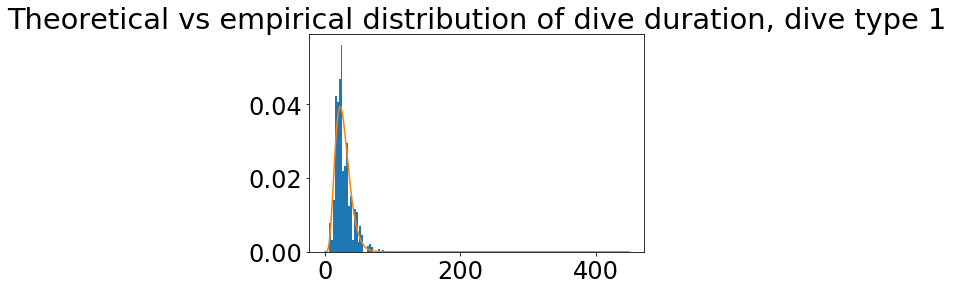

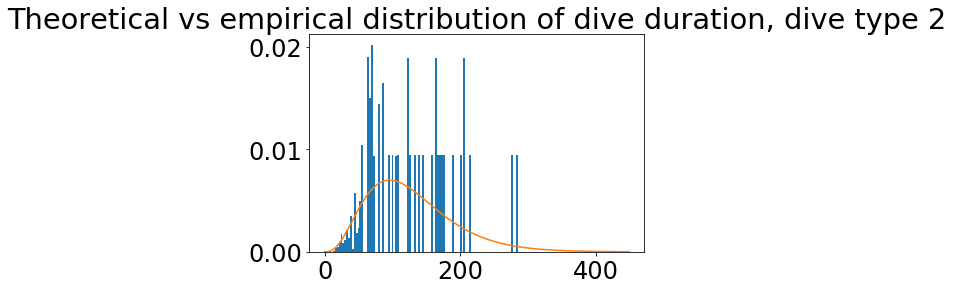

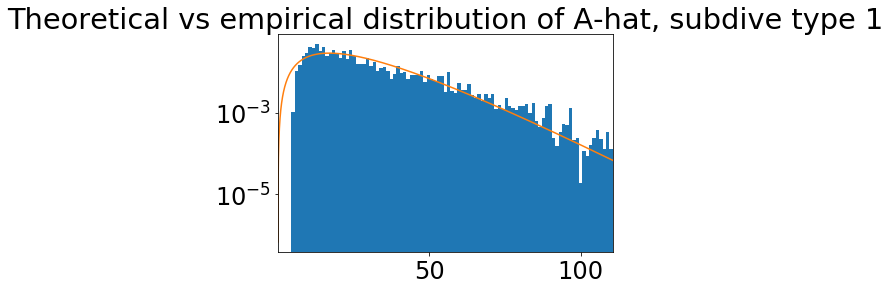

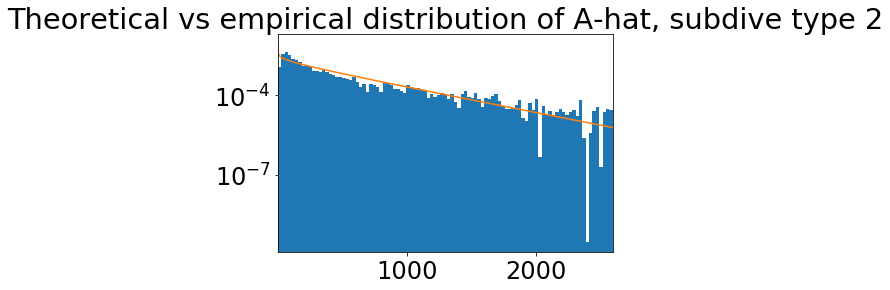

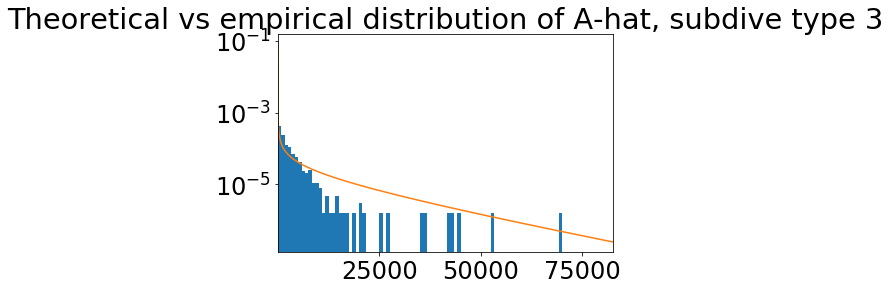

Ax


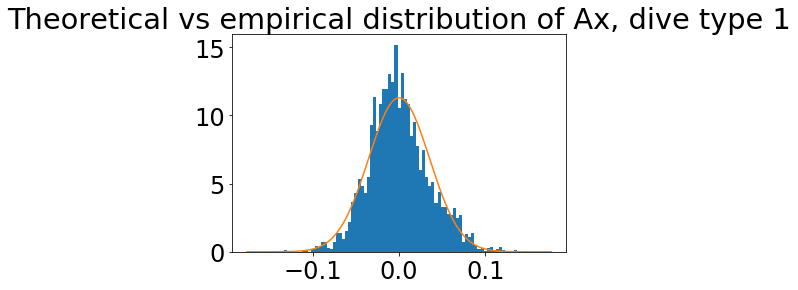

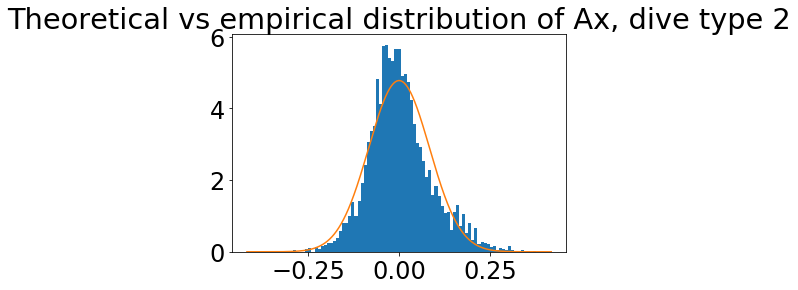

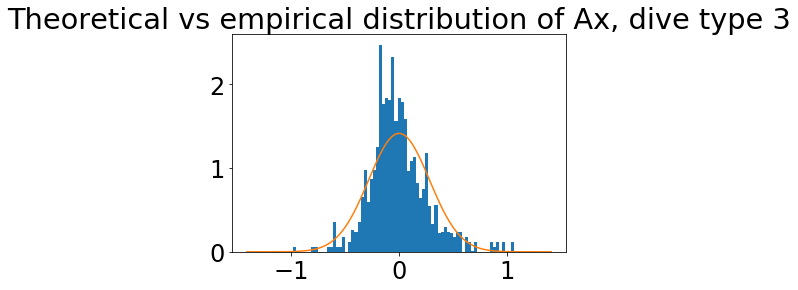

Ay


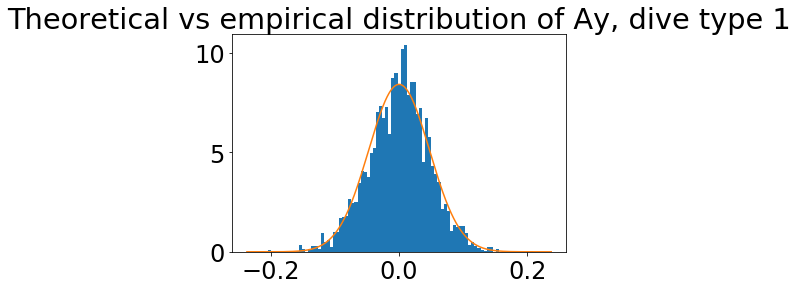

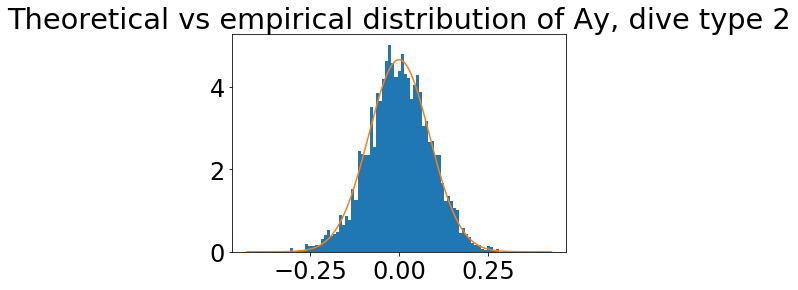

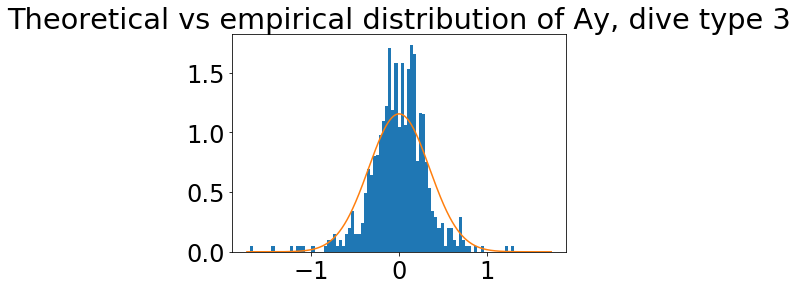

Az


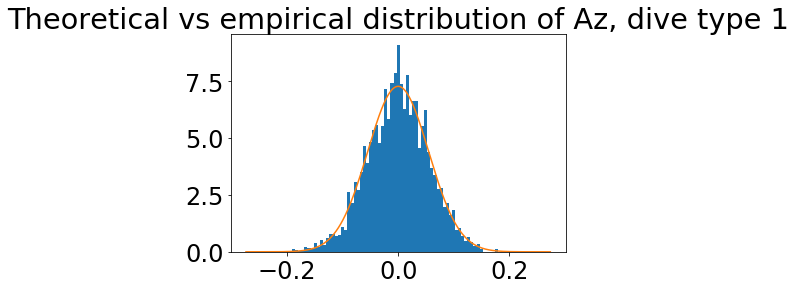

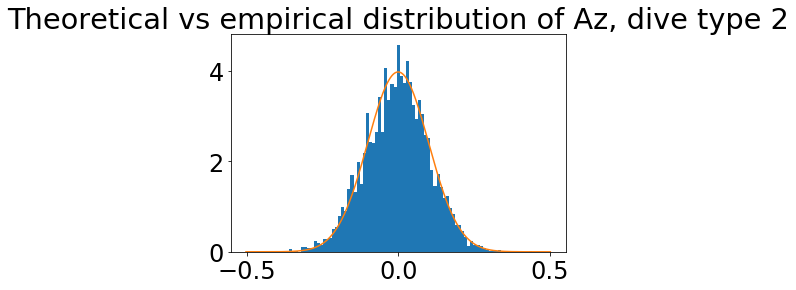

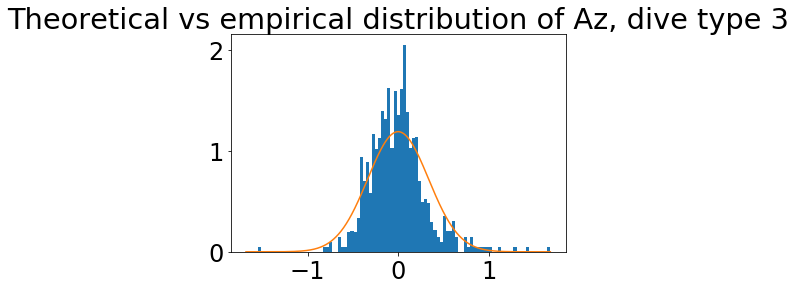

In [12]:
# dive duration
weights = [list([]),list([])]
values = []

for dive in data:
    weights[0].append(dive['dive_state_probs'][0])
    weights[1].append(dive['dive_state_probs'][1])
    values.append(dive['dive_duration'])
        
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)
    
for state in range(hhmm.pars.K[0]):
    x = np.linspace(0.01,np.max(mu)+5*np.max(sig),10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.hist(values,weights=weights[state],density=True,bins=100)
    plt.plot(x,y)
    plt.title('Theoretical vs empirical distribution of dive duration, dive type %d'%(state+1))
    plt.show()
    
    
    
# A-hat
weights = [list([]),list([]),list([])]
values = []

for dive in data:
    for seg in dive['subdive_features']:
        weights[0].append(seg['subdive_state_probs'][0])
        weights[1].append(seg['subdive_state_probs'][1])
        weights[2].append(seg['subdive_state_probs'][2])
        values.append(seg['Ahat_low'])
        
mu = hhmm.theta[1][0]['Ahat_low']['mu']
sig = hhmm.theta[1][0]['Ahat_low']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)
for state in range(hhmm.pars.K[1]):
    bins = np.linspace(0.01,mu[state]+5*sig[state],100)
    plt.hist(values,weights=weights[state],density=True,bins=bins)
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.plot(x,y)
    plt.title('Theoretical vs empirical distribution of A-hat, subdive type %d'%(state+1))
    plt.yscale('log')
    plt.xlim([min(x),max(x)])
    plt.show()
    
    
# Ax
for feature in ['Ax','Ay','Az']:
    print(feature)
    weights = [list([]),list([]),list([])]
    values = [list([]),list([]),list([])]

    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    corr = expit(hhmm.theta[1][0][feature]['corr'])

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                weights[state].append(seg['subdive_state_probs'][state])
                values[state].append(seg[feature] - (corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]))
                seg_tm1 = seg
                
    for state in range(hhmm.pars.K[1]):
        bins = np.linspace(-5*sig[state],5*sig[state],100)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins)
        x = np.linspace(-5*sig[state],5*sig[state],10000)
        y = norm.pdf(x,0,sig[state])
        plt.plot(x,y)
        plt.title('Theoretical vs empirical distribution of %s, dive type %d'%(feature,state+1))
        plt.show()

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning:

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



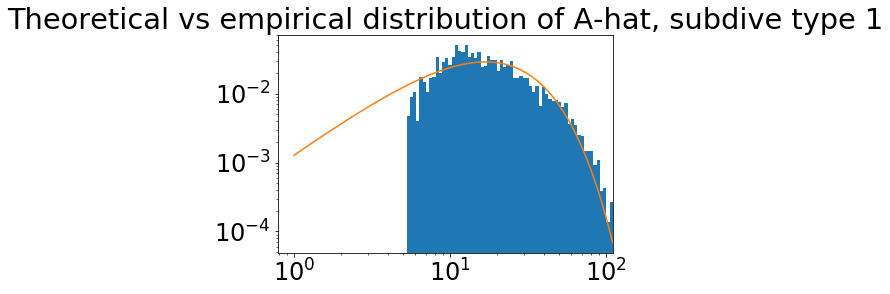

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning:

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



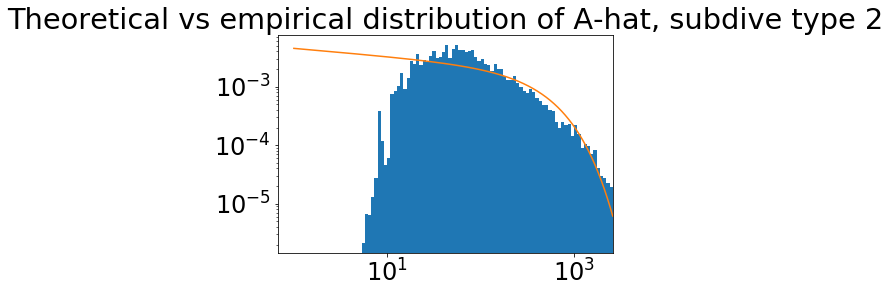

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning:

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



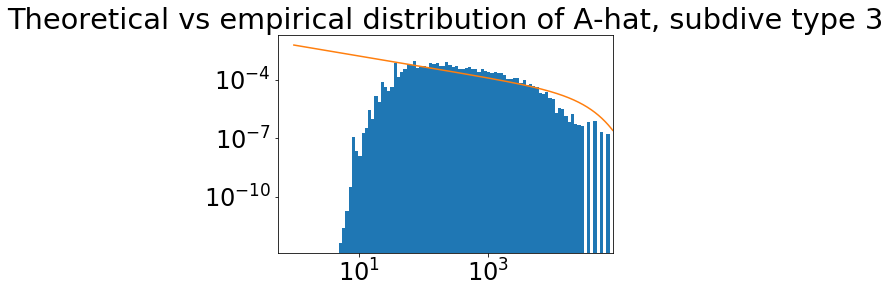

In [13]:
weights = [list([]),list([]),list([])]
values = []

for dive in data:
    for seg in dive['subdive_features']:
        weights[0].append(seg['subdive_state_probs'][0])
        weights[1].append(seg['subdive_state_probs'][1])
        weights[2].append(seg['subdive_state_probs'][2])
        values.append(seg['Ahat_low'])
        
mu = hhmm.theta[1][0]['Ahat_low']['mu']
sig = hhmm.theta[1][0]['Ahat_low']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)
for state in range(hhmm.pars.K[1]):
    bins = np.exp(np.linspace(np.log(1.0),np.log(mu[state]+5*sig[state]),100))
    plt.hist(values,weights=weights[state],density=True,bins=bins)
    x = np.linspace(1.0,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.plot(x,y)
    plt.title('Theoretical vs empirical distribution of A-hat, subdive type %d'%(state+1))
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([0,max(x)])
    plt.show()

# Psuedoresiduals

In [14]:
x = np.linspace(-5,5,1000)
y = norm.pdf(x)

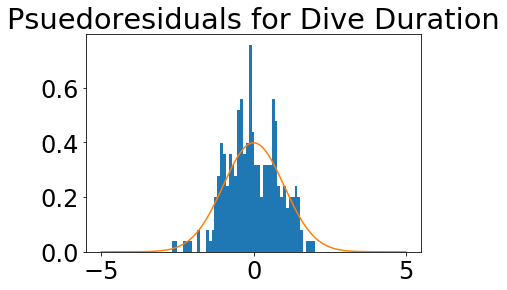

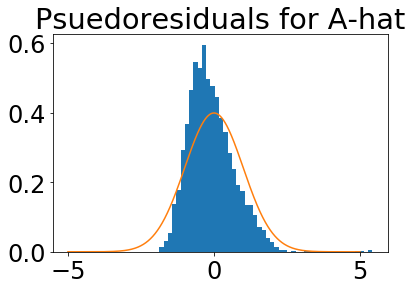

Ax


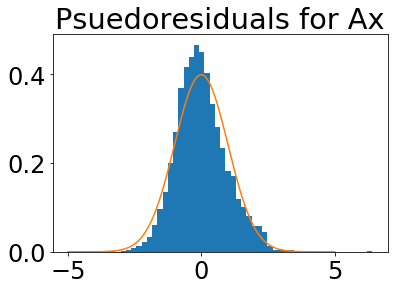

Ay


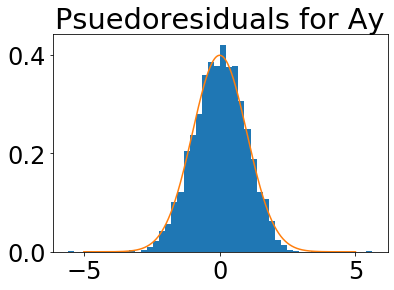

Az


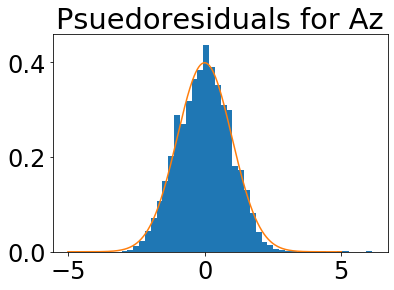

In [15]:
# dive duration
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

psuedoresids = []

for dive in data:
    cdf = 0
    for state in range(hhmm.pars.K[0]):
        cdf += dive['dive_state_probs'][state]* \
               gamma.cdf(dive['dive_duration'],
                         shape[state],0,scale[state])
    psuedoresids.append(norm.ppf(cdf))

plt.hist(psuedoresids,density=True,bins=50)
plt.title('Psuedoresiduals for Dive Duration')
plt.plot(x,y)
plt.show()

# A-hat
mu = hhmm.theta[1][0]['Ahat_low']['mu']
sig = hhmm.theta[1][0]['Ahat_low']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

psuedoresids = []

for dive in data:
    for seg in dive['subdive_features']:
        cdf = 0
        for state in range(hhmm.pars.K[1]):
            cdf += seg['subdive_state_probs'][state] * \
                    gamma.cdf(seg['Ahat_low'],
                              shape[state],0,scale[state])
        psuedoresids.append(norm.ppf(cdf))
        
plt.hist(psuedoresids,density=True,bins=50)
plt.title('Psuedoresiduals for A-hat')
plt.plot(x,y)
plt.show() 

for feature in ['Ax','Ay','Az']:
    print(feature)
    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    corr = expit(hhmm.theta[1][0][feature]['corr'])
    
    psuedoresids = []

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                cdf = 0
                for state in range(hhmm.pars.K[1]):
                    mean = corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]
                    cdf += seg['subdive_state_probs'][state] * \
                            norm.cdf(seg[feature],
                                      mean,sig[state])
                seg_tm1 = seg
                psuedoresids.append(norm.ppf(cdf))
                
    plt.hist(psuedoresids,density=True,bins=50)
    plt.title('Psuedoresiduals for %s'%feature)
    plt.plot(x,y)
    plt.show()   